In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder

In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/


In [11]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session
sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = 2, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   minimum_time_point = "V08",
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced")


retaining all patient who have at least passed the Base Line Visit...
matchin_entries ['PPMI-Phase1-IR2.3185.V04.0003156143.5104-SL-1397.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3619.V08.PP0048-2990.5104-SL-1062.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3008.V04.0003122858.5104-SL-0980.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3361.V06.0003166713.5104-SL-0987.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3661.V02.0003449539.5104-SL-3470.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3365.V04.0003122891.5104-SL-0252.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3444.V08.0000309245.5104-SL-1024.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3653.V06.0003185639.5104-SL-0930.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.4135.V06.0000296623.5104-SL-1272.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3481.V04.0003288284.5104-SL-0284.longRNA-NEBKAP.salmon-gtf

BL : loaded 4445 samples

V02 : loaded 3200 samples

V04 : loaded 2822 samples

V06 : loaded 2305 samples

V08 : loaded 1585 samples





In [ ]:



#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True, batch_size = 128)

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"], # LASSO selection
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = None, 
                                                   feature_selection_proceedure = "LASSO", 
                                                   retain_phases="2", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params)

best estimator: SGDClassifier(alpha=0.2, loss='log', penalty='l1')


In [12]:
latent_dim = 256

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [13]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [5]:
%tensorboard --logdir ../workfiles/logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [14]:
hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb)

Epoch 1/2000


2023-08-07 14:41:26.195194: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


25/25 [==============================] - 8s 293ms/step - loss: 388156.5180 - lr: 0.0010
Epoch 2/2000
25/25 [==============================] - 7s 282ms/step - loss: 220929.4056 - lr: 0.0010
Epoch 3/2000
25/25 [==============================] - 8s 324ms/step - loss: 64300.8093 - lr: 0.0010
Epoch 4/2000
25/25 [==============================] - 5s 214ms/step - loss: 35396.6105 - lr: 0.0010
Epoch 5/2000
25/25 [==============================] - 5s 207ms/step - loss: 33209.0657 - lr: 0.0010
Epoch 6/2000
25/25 [==============================] - 6s 224ms/step - loss: 28125.7117 - lr: 0.0010
Epoch 7/2000
25/25 [==============================] - 6s 258ms/step - loss: 21659.3696 - lr: 0.0010
Epoch 8/2000
25/25 [==============================] - 6s 239ms/step - loss: 18302.8125 - lr: 0.0010
Epoch 9/2000
25/25 [==============================] - 6s 233ms/step - loss: 16777.8576 - lr: 0.0010
Epoch 10/2000
25/25 [==============================] - 7s 292ms/step - loss: 16103.3158 - lr: 0.0010
Epoch 11/2

In [15]:
autoencoder.load_weights(checkpoint_filepath)


[297991.96875, 159784.46875, 55504.08203125, 33699.6328125, 31916.927734375, 26112.78515625, 20380.359375, 17636.76171875, 16434.90625, 15802.7998046875, 14950.072265625, 13388.0693359375, 11322.97265625, 11257.62109375, 11700.6220703125, 11457.720703125, 13554.6396484375, 11246.2978515625, 8780.0, 7814.81689453125, 7439.41748046875, 6867.5888671875, 6621.0283203125, 6351.94189453125, 6155.361328125, 5918.12255859375, 5824.01123046875, 5658.712890625, 5705.8544921875, 6049.92919921875, 6170.515625, 5753.02294921875, 5341.98974609375, 5000.28662109375, 5021.02880859375, 5176.52001953125, 5273.44482421875, 5101.32666015625, 5269.7314453125, 5514.79296875, 6128.3828125, 5491.880859375, 5646.62451171875, 6014.17041015625, 6338.20263671875, 5242.86767578125, 4758.00439453125, 4315.18505859375, 4257.9130859375, 4789.22119140625, 4869.03369140625, 4443.7607421875, 4113.52880859375, 4225.99560546875, 4093.7314453125, 4055.477294921875, 5252.1279296875, 5444.42138671875, 5094.81982421875, 5505.

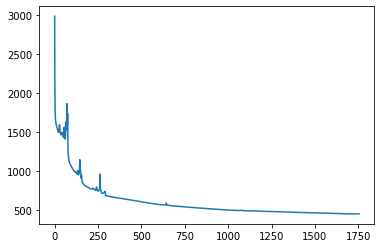

In [16]:
plt.plot(hist.history['loss'][100:])
print(hist.history['loss'])




### some diagnosis

In [17]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(64, 256), dtype=float32, numpy=
array([[  227.94418  ,  -781.9994   ,   521.8803   , ...,   284.8704   ,
          -34.396206 ,   318.2458   ],
       [ -148.70612  ,  -878.6095   ,   285.353    , ...,  -417.66464  ,
           30.616297 ,   943.9752   ],
       [  447.17828  ,  -558.693    ,  -837.25616  , ...,   303.2679   ,
         -181.90738  ,  1178.56     ],
       ...,
       [  319.70233  ,   136.10158  , -1092.7863   , ...,   375.7952   ,
          -10.751494 ,  2242.9253   ],
       [   38.90006  ,  -374.0673   ,  -327.38187  , ...,   699.04083  ,
          -67.52155  ,  1166.9802   ],
       [  897.317    ,  -127.22405  ,    -6.1716347, ...,   519.9567   ,
          -85.84532  ,   634.054    ]], dtype=float32)>

In [18]:
print(autoencoder.decoder(z))
print(e)

tf.Tensor(
[[ 5.69382858e+01  3.97391968e+01  1.34740076e+01 ...  4.75097168e+02
   8.60459534e+02  3.95525055e+02]
 [-2.40806174e+00  7.67355423e+01  8.40502262e+00 ...  9.21894608e+01
   1.09732216e+02  1.08619957e+02]
 [-3.28222513e+00  2.52265549e+01  6.89128542e+00 ...  4.90791283e+01
   1.56770077e+01  1.03740128e+02]
 ...
 [ 1.15546188e+01  2.86769271e-01  7.22293139e+00 ...  3.06905365e+01
   2.74884529e+01  4.93328934e+01]
 [ 1.38114953e+00  6.68830261e+02  6.96002245e+00 ...  9.43672333e+01
   1.13550514e+02  1.33740051e+02]
 [ 2.66412277e+01 -9.11781025e+00  1.20993662e+01 ...  1.81442078e+02
   1.63287766e+02  2.68017426e+02]], shape=(64, 14864), dtype=float32)
tf.Tensor(
[[ 56.9107   56.2618   12.0774  ... 346.531   649.73    311.662  ]
 [  7.51996  51.2367    8.32409 ... 131.13    137.239   149.522  ]
 [  3.57237  41.1205    8.62556 ...  52.8186   24.75    101.512  ]
 ...
 [  1.61202  54.2136    5.29515 ...  34.2686   43.29     57.0898 ]
 [  9.1779  181.323    10.5255  ..

In [19]:
autoencoder.encoder.save('../workfiles/simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


In [20]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

25/25 [==============================] - 0s 8ms/step


In [21]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [22]:
df.to_csv("../workfiles/processed_data.csv", index=False)
